# ABL with MMC demo

In [1]:
# Load the modules

# Add any possible locations of amr-wind-frontend here
amrwindfedirs = ['/projects/wind_uq/lcheung/amrwind-frontend/',
                 '/ccs/proj/cfd162/lcheung/amrwind-frontend/']
import sys, os, shutil
for x in amrwindfedirs: sys.path.insert(1, x)
import MMCutil as writeMMC

# Load the libraries
import numpy as np
import pandas as pd
import amrwind_frontend as amrwind
import matplotlib.pyplot    as plt
from scipy.interpolate import CubicSpline

# Also ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Make all plots inline 
%matplotlib inline

In [2]:
# Start the case
case = amrwind.MyApp.init_nogui()

In [3]:
# Set the time constants
case.setAMRWindInput('time.stop_time', 10800.0)
case.setAMRWindInput('time.max_step',  -1)

case.setAMRWindInput('time.fixed_dt',  0.50)
case.setAMRWindInput('time.checkpoint_interval',  -1)

In [4]:
# Set some basic parameters
case.setAMRWindInput('incflo.physics',      ['ABL'])  # Must have ABL physics to do ABL calculations
case.setAMRWindInput('incflo.verbose',      3)        # This is optional, verbose=3 means more info in the output logs
case.setAMRWindInput('io.check_file',       'chk')    # What to name the checkpoint files

case.setAMRWindInput('incflo.use_godunov',  True)       # Always use a godunov scheme
case.setAMRWindInput('incflo.godunov_type', 'weno_z')   # Use 'weno_z' 

case.setAMRWindInput('turbulence.model',    ['OneEqKsgsM84'])    # One equation k-sgs subgrid scale model
case.setAMRWindInput('TKE.source_terms',    ['KsgsM84Src'])      # The corresponding source term

case.setAMRWindInput('transport.viscosity', 1.771e-05)           # dynamic viscosity, based on median air temperature of 284.47 K from 2 m above E06, units Pa-s
case.setAMRWindInput('incflo.density',      1.2456)              # density, based on 1017.13*100./(284.47)/287.058 where 1017.13 is median air pressure from 2 m above E06 
                                                                 #   and 284.47 is median air temperature from 2 m above E06, units kg/
case.setAMRWindInput('incflo.velocity',      [0, 0, 0])

In [5]:
# To set up the sampling output
case.setAMRWindInput('time.plot_interval',        -1) 

In [6]:
# Set some tolerances (leave this alone)
tols = """
nodal_proj.mg_rtol                       = 1e-06               
nodal_proj.mg_atol                       = 1e-12               
mac_proj.mg_rtol                         = 1e-06               
mac_proj.mg_atol                         = 1e-12               
diffusion.mg_rtol                        = 1e-06               
diffusion.mg_atol                        = 1e-12               
temperature_diffusion.mg_rtol            = 1e-10               
temperature_diffusion.mg_atol            = 1e-13               
"""
case.loadAMRWindInput(tols, string=True);

#case.setAMRWindInput('incflo.do_initial_proj', 0)
#case.setAMRWindInput('incflo.initial_iterations', 0)


In [7]:
# Sets up the domain and level 0 mesh
case.setAMRWindInput('geometry.prob_lo', [   0.0,    0.0, 0.0 ])
case.setAMRWindInput('geometry.prob_hi', [3840.0,  3840.0, 960.0])   # each number must be divisible by 16
case.setAMRWindInput('amr.n_cell',       [192,     192,     48])

In [8]:
# This cell sets up boundary conditions
case.setAMRWindInput('is_periodicx', True)     # periodic in x
case.setAMRWindInput('is_periodicy', True)     # periodic in y
case.setAMRWindInput('is_periodicz', False)    # Enforce some boundary conditions in z

In [9]:
# Boundary conditions in z
case.setAMRWindInput('zlo.type',              'wall_model')          
case.setAMRWindInput('zlo.tke_type',          'zero_gradient')       
case.setAMRWindInput('zhi.type',              'slip_wall')           
case.setAMRWindInput('zhi.temperature_type',  'fixed_gradient')    

In [10]:
# Now set up ABL specific forces, parameters, etc.
case.setAMRWindInput('ICNS.source_terms',            ['BoussinesqBuoyancy','ABLMesoForcingMom',])
#case.setAMRWindInput('Temperature.source_terms',     ['ABLMesoForcingTemp',])

case.setAMRWindInput('ABL.stats_output_frequency',   1, forcechange=True)           # Output ABL stats every iteration            
case.setAMRWindInput('ABL.stats_output_format',   'netcdf', forcechange=True)       # Use netcdf output because that's how we postprocess

case.setAMRWindInput('ABLForcing.abl_forcing_height',   150)       # Hub height wind speed you want specify 
case.setAMRWindInput('ABL.kappa',                       0.4)      # Kolmogorov constant

case.setAMRWindInput('ABL.normal_direction',      2)              # vertical is in z
case.setAMRWindInput('ABL.surface_roughness_z0',  0.0001)           # Surface roughess, SOMETHING WE WILL PROBABLY WANT TO ITERATE ON
case.setAMRWindInput('ABL.reference_temperature', 300.0)        # Correspond to what was measured at ARM

case.setAMRWindInput('ABL.perturb_temperature',    True, forcechange=True)
case.setAMRWindInput('ABL.perturb_velocity',       True, forcechange=True)

# Monin-Obukhov parameters (No need to change)
case.setAMRWindInput('ABL.mo_beta_m',             16.0)
case.setAMRWindInput('ABL.mo_gamma_m',            5.0)
case.setAMRWindInput('ABL.mo_gamma_h',            5.0)
case.setAMRWindInput('ABL.random_gauss_mean',     0.0)
case.setAMRWindInput('ABL.random_gauss_var',      1.0)

case.setAMRWindInput('BoussinesqBuoyancy.reference_temperature', 300.0)

CANNOT update: ABLMeanBoussinesq use forcechange=True in setval()


## Add sampling planes

In [11]:
# Delete all old sampling planes from precursor
case.listboxpopupwindict['listboxsampling'].deleteall()
case.listboxpopupwindict['listboxpostprosetup'].deleteall()

In [12]:
samplingcsv="""
# CSV file should have columns withturbinescsv=
# name, type, upstream, downstream, lateral, below, above, n1, n2, options
name, type, upstream, downstream, lateral, below, above, n1, n2, options
#cl1, centerline, 1,  0, none, none,  none,  11, 11, none
#rp1, rotorplane, 2,  0, none, none,  none,  11, 11, none
#sw1, streamwise, 2,  1, 1, 0.5,  0.5,  11, 11, usedx:0.25 noffsets:1
sw1, streamwise,  2,  1, 1, 0.5,  0.5,  11, 11, usedx:10 wholedomain:1 units:meter center:specified centerx:500 centery:500 centerz:150 orientation:y outputvars:velocity;tke;temperature outputfreq:10 outputto:sw_
hh,  hubheight,   0,  0,1000, 0,  none,  11, 11, usedx:10 wholedomain:1 units:meter center:specified centerx:0 centery:0 centerz:150 outputvars:velocity;tke;temperature outputfreq:10 outputto:hubheight_
"""

In [13]:
case.setAMRWindInput('sampling_csvtextbox', samplingcsv)
case.setAMRWindInput('sampling_deleteprev', True)
case.sampling_createAllProbes(verbose=False)
# Print out existing list of turbines
print(case.listboxpopupwindict['listboxsampling'].getitemlist())

['Farm_sw1', 'Farm_hh']


## MMC parameters

In [14]:
# Merging profiles
def tanhblend(x, x0, w):
    return 0.5*(1+np.tanh((x-x0)/w))

def tanhblendprofiles(profa, profb, x, x0, w):
    tanha = profa*(1-tanhblend(x, x0, w))
    tanhb = profb*(tanhblend(x, x0, w))
    return tanha + tanhb

def interpprofile(newz, z, prof):
    spl = CubicSpline(z, prof)
    interpprof = spl(newz)
    return interpprof
    #return np.interp(newz, z, prof)
    
def blendprofiles(newz, zA, profA, Bconst, x0, w):
    newprofA = interpprofile(newz, zA, profA)
    newprofB = Bconst*np.ones(len(newz)) #interpprofile(newz, zB, profB)
    return tanhblendprofiles(newprofA, newprofB, newz, x0, w)

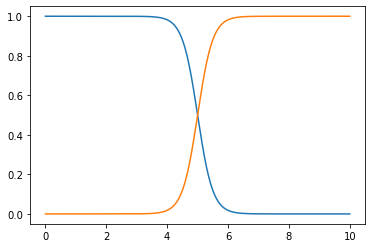

In [15]:
xlinspace=np.linspace(0,10,1001)
plt.plot(xlinspace, 1-tanhblend(xlinspace, 5.0, 0.50))
plt.plot(xlinspace, tanhblend(xlinspace, 5.0, 0.50))

In [16]:
fullheights = np.array([10, 20,  40,  60,  80, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280, 300, 400]) 
fullheights = np.concatenate((fullheights, np.arange(410, 1001, 10)))
print(fullheights)

[  10   20   40   60   80  100  120  140  160  180  200  220  240  260
  280  300  400  410  420  430  440  450  460  470  480  490  500  510
  520  530  540  550  560  570  580  590  600  610  620  630  640  650
  660  670  680  690  700  710  720  730  740  750  760  770  780  790
  800  810  820  830  840  850  860  870  880  890  900  910  920  930
  940  950  960  970  980  990 1000]


In [17]:
rundir      = 'MMCdemo_neutral1/'
ICfilename  = 'neutral_init.nc'
MMCfilename = 'neutral_MMC.nc'
amrfilename = 'abl_neutralMMC.inp'

# Go to the run directory
if not os.path.exists(rundir):
    os.makedirs(rundir)

In [18]:
# Load the data from the csv file
csvfile = '../NOW23_analysis/data/neutral_profile.csv'
profile = pd.read_csv(csvfile)

In [19]:
print(profile.columns)
print(np.array(profile['height']))
#np.array(profile['u'])

Index(['height', 'temperature', 'wind_speed', 'u', 'v', 'surface_heat_flux'], dtype='object')
[ 10  20  40  60  80 100 120 140 160 180 200 220 240 260 280 300 400 500]


In [20]:
# Let's look at the original data
zMMC     = np.array(profile['height'])     # heights of the MMC forcing
times    = [0, 100000.0]    # Times of the MMC forcing

# Merge the profiles
extendedu = blendprofiles(fullheights, zMMC, np.array(profile['u']),  np.array(profile['u'])[-1]*1.0, 450, 35)
extendedv = blendprofiles(fullheights, zMMC, np.array(profile['v']),  np.array(profile['v'])[-1]*1.0, 450, 35)
extendedT = blendprofiles(fullheights, fullheights, 300*np.ones(len(fullheights)),  305, 475, 35)

# U profiles from mesoscale
udat = np.array([extendedu,
                 extendedu
                ])

# V profiles from mesoscale
vdat = np.array([extendedv,
                 extendedv
             ])

density = case.getAMRWindInput('incflo.density')
cp      = 1005 # J/(kg*K)
q       = np.mean(np.array(profile['surface_heat_flux']))/(density*cp)
print('q = '+repr(q))
# T profiles from mesoscale
#Tdat = np.array([np.array(profile['temperature']),
#                 np.array(profile['temperature']),
#                ])
Tdat = np.array([extendedT,
                 extendedT,
                ])

fluxdat     = q*np.array(times)
tstart      = 0.0


q = -0.002077640378710174


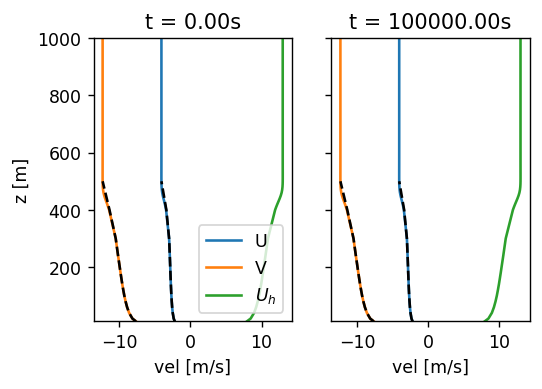

In [21]:
# Plot the MMC inputs
plottimes = [0, -1]

fig, axs = plt.subplots(1, len(plottimes), figsize=(2.25*len(plottimes), 3), dpi=125, sharey=True)
for ploti, itime in enumerate(plottimes):
    axs[ploti].plot(udat[itime, :], fullheights, label='U')
    axs[ploti].plot(vdat[itime, :], fullheights, label='V')
    axs[ploti].plot(np.sqrt(udat[itime, :]**2+vdat[itime, :]**2), fullheights, label='$U_h$')
    axs[ploti].set_title('t = %0.2fs'%times[itime])
    axs[ploti].set_xlabel('vel [m/s]')
    
    axs[ploti].plot(np.array(profile['u']), zMMC, 'k--')
    axs[ploti].plot(np.array(profile['v']), zMMC, 'k--')
axs[0].set_ylabel('z [m]')
axs[0].set_ylim([min(fullheights), max(fullheights)])
axs[0].legend()

(10.0, 1000.0)

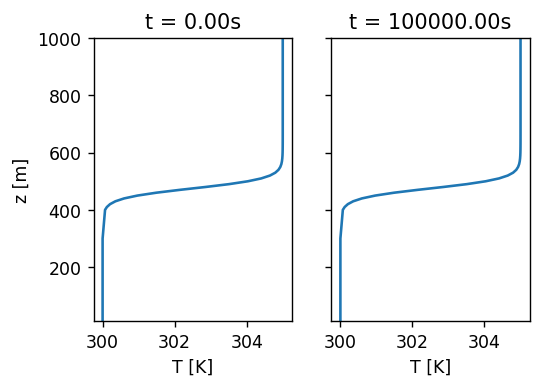

In [22]:
# Plot the MMC inputs
plottimes = [0, -1]

fig, axs = plt.subplots(1, len(plottimes), figsize=(2.25*len(plottimes), 3), dpi=125, sharey=True)
for ploti, itime in enumerate(plottimes):
    axs[ploti].plot(Tdat[itime, :], fullheights)
    axs[ploti].set_title('t = %0.2fs'%times[itime])
    axs[ploti].set_xlabel('T [K]')
    
    #axs[ploti].plot(np.array(profile['temperature']), zMMC, 'k--')
axs[0].set_ylabel('z [m]')
axs[0].set_ylim([min(fullheights), max(fullheights)])

In [23]:
# Set the MMC inputs
zstr, Tstr = writeMMC.makeIC_fromMMC(case.getAMRWindInput('geometry.prob_lo'), 
                                     case.getAMRWindInput('geometry.prob_hi'), 
                                     case.getAMRWindInput('amr.n_cell'), 
                                     udat, vdat, Tdat,
                                     times, fullheights, rundir+'/'+ICfilename, tstart, verbose=True)
writeMMC.makeMMCforcing(case.getAMRWindInput('geometry.prob_lo'), 
                        case.getAMRWindInput('geometry.prob_hi'), 
                        case.getAMRWindInput('amr.n_cell'), 
                        udat, vdat, Tdat, fluxdat,
                        times, fullheights, rundir+'/'+MMCfilename)

# These inputs set up the initial temperature profile (Same as Nalu-Wind temperature profile)
case.setAMRWindInput('ABL.temperature_heights', zstr)
case.setAMRWindInput('ABL.temperature_values',  Tstr)

# MMC files
case.setAMRWindInput('ABL.initial_condition_input_file', ICfilename) # this is only for u,v
case.setAMRWindInput('ABL.mesoscale_forcing', MMCfilename)

case.setAMRWindInput('ABLMesoForcingMom.forcing_scheme', "direct")
#case.setAMRWindInput('ABLMesoForcingTemp.forcing_scheme', "direct")

#case.setAMRWindInput('ABLMesoForcingMom.forcing_transition',  "directToConstant")
#case.setAMRWindInput('ABLMesoForcingTemp.forcing_transition', "directToConstant")
#case.setAMRWindInput('ABLMesoForcingMom.constant_transition_height',  450.0)
#case.setAMRWindInput('ABLMesoForcingTemp.constant_transition_height', 450.0)
#case.setAMRWindInput('ABLMesoForcingMom.transition_thickness',  100.0)
#case.setAMRWindInput('ABLMesoForcingTemp.transition_thickness', 100.0)



[============================================================] 100.0% 
[============================================================] 100.0% 
[============================================================] 100.0% 
NETCDF4
Wrote heights and times
Wrote momentum profiles
Wrote temperature profiles
Wrote tflux profiles
Done


In [24]:
# Estimate mesh size
case.estimateMeshSize(verbose=False)

ESTIMATED MESH SIZE
   Level       Ncells                      Cell Size
       0      1769472             20.0 x 20.0 x 20.0
  TOTAL:      1769472


In [25]:
# Write the input file
#print(case.writeAMRWindInput('ablmmc.inp'))
print(case.writeAMRWindInput(rundir+'/'+amrfilename))

# --- Simulation time control parameters ---
time.stop_time                           = 10800.0             # Max (simulated) time to evolve [s]
time.max_step                            = -1                  
time.fixed_dt                            = 0.5                 # Fixed timestep size (in seconds). If negative, then time.cfl is used
time.checkpoint_interval                 = -1                  
incflo.physics                           = ABL                 # List of physics models to include in simulation.
incflo.verbose                           = 3                   
io.check_file                            = chk                 
incflo.use_godunov                       = true                
incflo.godunov_type                      = weno_z              
turbulence.model                         = OneEqKsgsM84        
TKE.source_terms                         = KsgsM84Src          
nodal_proj.mg_rtol                       = 1e-06               
nodal_proj.mg_atol             